In [1]:
from data_loader import DataGenerator
from datetime import datetime
from model import model_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, tb_logs_path, model_checkpoint_file, test_seq_path)
from tensorflow.keras.losses import MSE, MAE
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support as prf_score
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm
np.set_printoptions(suppress=True)

In [2]:
def get_err_of_model(model, X, err_f, shape):
    preds = model.predict(X)
    errs = err_f(X.reshape(shape), preds.reshape(shape))
    err_of_mods = []
    for i, m_ix in enumerate(modifs_idx):
        if m_ix.shape[0] > 3 and m_ix.shape[0] < 50:
            err_of_mods.append(err_f(X[i, m_ix].flatten(),
                                     preds[i, m_ix].flatten()))
    overall_err = np.mean(errs)
    mods_err = np.mean(err_of_mods)
    return {"err": overall_err, "modifications_err": mods_err}

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_roll_mses(signal, pred):
    roll_mses = []
    for idx in rolling_window(np.arange(signal.shape[0]), 25):
        roll_mses.append(np.median(MSE(signal[idx], pred[idx])))
    return np.array(roll_mses)

def get_y(X, preds, modifs_idx, threshold):
    y_true = []
    y_pred = []
    for sample, pred, mod_ix in tqdm(zip(X, preds, modifs_idx)):
        if np.median(MSE(sample, pred)) > threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)
        if mod_ix.shape[0] > 3:
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true, y_pred

def get_y_from_rolling(X, preds, modifs_idx, threshold):
    y_true = []
    y_pred = []
    for sample, pred, mod_ix in tqdm(zip(X, preds, modifs_idx)):
        mses = get_roll_mses(sample, pred)
        if np.where(mses > threshold):
            y_pred.append(1)
        else:
            y_pred.append(0)
        if mod_ix.shape[0] > 1:
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true, y_pred

In [3]:
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 14,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 256,
 'load2ram': False,
 'test': False}

In [4]:
data_generator_config['quality_threshold'] = 20.5
data_generator_config['test'] = True
data_generator_config['seq_path'] = test_seq_path
data_generator_config['load2ram'] = False
data_generator_config['step_len'] = 128
# data_generator_config['motifs'] = ["CCAGG", "CCTGG", "GATC"]
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 20.5,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 128,
 'load2ram': False,
 'test': True,
 'seq_path': '/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5'}

In [5]:
data_loader = DataGenerator(**data_generator_config)

/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5


In [6]:
X = []
modifs_idx = []
for _ in tqdm(range(160)):
    x, m_idx = next(data_loader)
    X.append(x)
    modifs_idx.append(m_idx)

 14%|█▍        | 22/160 [00:48<04:30,  1.96s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160809_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_2_08_07_16_80510_ch180_read404_strand.fast5


 93%|█████████▎| 149/160 [05:35<00:18,  1.67s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch432_read1037_strand.fast5


100%|██████████| 160/160 [05:55<00:00,  2.22s/it]


In [8]:
X = np.array(X).reshape(160000, 512, 1)
modifs_idx = np.array(modifs_idx).reshape(160000, 1)
modifs_idx = modifs_idx.flatten()

In [10]:
clear_session()
model = load_model(r"1711/model.30-0.03.h5")
print("MSE: ", get_err_of_model(model, X, MSE, (160000, 512)))
print("MAE: ", get_err_of_model(model, X, MAE, (160000, 512)))
preds = model.predict(X)

MSE:  {'err': 0.035561223, 'modifications_err': 0.053696837}
MAE:  {'err': 0.13253272, 'modifications_err': 0.16362655}


rozdiel je prilis maly kvoli koncom

In [11]:
with_modif = np.array([i for i, ix in enumerate(modifs_idx) if len(ix)])
without_modif = np.array([i for i, ix in enumerate(modifs_idx) if not len(ix)])
print(with_modif.shape)
print(without_modif.shape)

(41334,)
(118666,)


In [12]:
y_true, y_pred = get_y(X, preds, modifs_idx, threshold=0.045)
print("acc: ", accuracy_score(y_true, y_pred))
print("precision, recall, f1, occ: \n", np.array(prf_score(y_true, y_pred)))

160000it [02:03, 1290.77it/s]


acc:  0.74411875
precision, recall, f1, occ: 
 [[     0.74423809      0.03703704]
 [     0.99978167      0.00002444]
 [     0.85328804      0.00004885]
 [119084.          40916.        ]]


In [17]:
X_cropped = X[:, 100:-100]
preds_cropped = preds[:, 100:-100]
print(preds_cropped.shape)
print(X_cropped.shape)

(160000, 312, 1)
(160000, 312, 1)


In [20]:
with_modif

array([    11,     12,     13, ..., 159980, 159981, 159982])

In [21]:
modif_ix = []
with_modifs = []
for i, ix in enumerate(with_modif):
    if modifs_idx[ix][0] > 200 and modifs_idx[ix][-1] < 312:
        modif_ix.append(modifs_idx[ix] - 100)
        with_modifs.append(i)

In [23]:
with_modifs

[2,
 6,
 13,
 22,
 38,
 49,
 52,
 62,
 79,
 82,
 88,
 97,
 101,
 108,
 116,
 142,
 162,
 177,
 184,
 187,
 197,
 211,
 234,
 238,
 244,
 247,
 259,
 265,
 269,
 284,
 301,
 307,
 322,
 328,
 332,
 335,
 338,
 341,
 364,
 379,
 396,
 402,
 429,
 432,
 442,
 451,
 467,
 477,
 486,
 490,
 500,
 510,
 539,
 550,
 574,
 583,
 587,
 596,
 613,
 616,
 622,
 626,
 636,
 647,
 656,
 668,
 673,
 681,
 686,
 696,
 700,
 706,
 721,
 756,
 762,
 774,
 779,
 788,
 804,
 814,
 820,
 823,
 828,
 838,
 842,
 848,
 863,
 874,
 878,
 888,
 898,
 905,
 913,
 920,
 927,
 945,
 962,
 973,
 977,
 987,
 1011,
 1015,
 1021,
 1026,
 1035,
 1057,
 1067,
 1081,
 1091,
 1106,
 1117,
 1124,
 1131,
 1146,
 1155,
 1159,
 1162,
 1169,
 1172,
 1178,
 1195,
 1206,
 1234,
 1242,
 1250,
 1264,
 1290,
 1300,
 1303,
 1312,
 1320,
 1335,
 1344,
 1349,
 1375,
 1382,
 1386,
 1396,
 1410,
 1416,
 1420,
 1444,
 1459,
 1469,
 1507,
 1524,
 1543,
 1553,
 1557,
 1563,
 1570,
 1573,
 1583,
 1586,
 1589,
 1593,
 1597,
 1606,
 1621,
 

In [19]:
np.mean(MSE(X_cropped[without_modif], preds_cropped[without_modif]))

0.034484256

In [24]:
np.mean(MSE(X_cropped[with_modifs], preds_cropped[with_modifs]))

0.034257077

In [25]:
X_cropped[with_modifs[9]]

array([[-0.36967227],
       [-0.32427392],
       [-0.02594191],
       [ 0.04539835],
       [ 0.10376765],
       [ 0.03242739],
       [ 0.07134026],
       [ 0.07134026],
       [ 0.07134026],
       [ 0.05188383],
       [ 0.0907967 ],
       [ 0.09728218],
       [ 0.21402079],
       [ 0.19456435],
       [ 0.149166  ],
       [ 0.14268052],
       [ 0.11025313],
       [ 0.12970957],
       [ 0.18159339],
       [ 0.11673861],
       [ 0.05188383],
       [ 0.19456435],
       [ 0.149166  ],
       [ 0.03891287],
       [ 0.30481748],
       [ 0.49938183],
       [ 0.46695444],
       [ 0.4799254 ],
       [ 0.6290914 ],
       [ 0.51235279],
       [ 0.60963497],
       [ 0.60963497],
       [ 0.65503332],
       [ 0.5707221 ],
       [ 0.61612044],
       [ 0.60314949],
       [ 0.70043166],
       [ 0.5707221 ],
       [ 0.54478018],
       [ 0.60314949],
       [ 0.48641088],
       [ 0.49938183],
       [ 0.43452705],
       [ 0.48641088],
       [ 0.45398349],
       [ 0

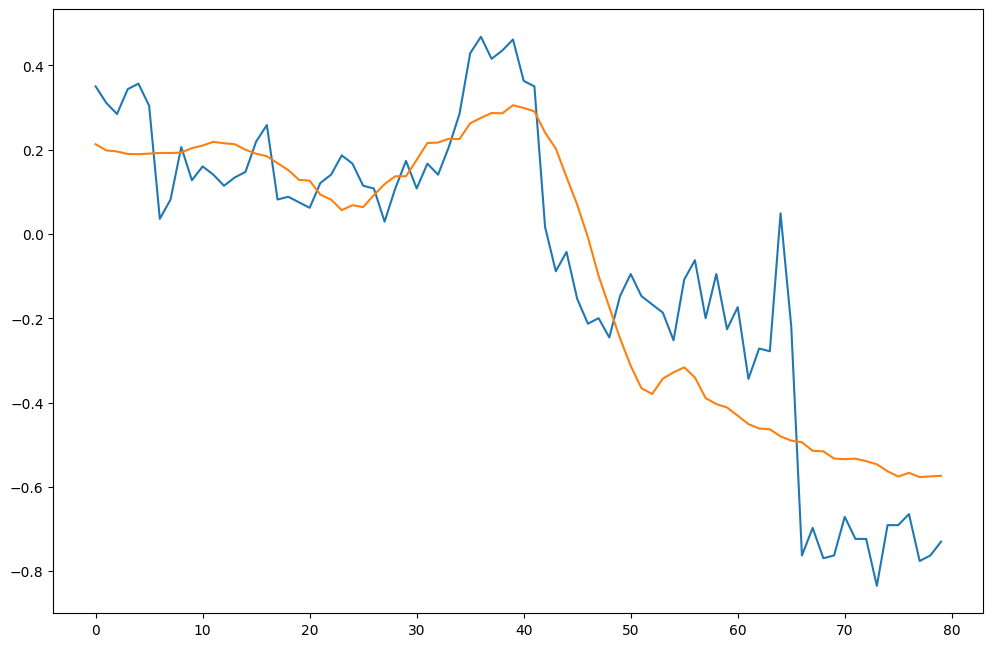

<Figure size 2000x2000 with 0 Axes>

In [24]:
preds = model.predict(X)
from matplotlib import pyplot as plt
plt.plot(X[29].flatten())
plt.plot(preds[29].flatten())
plt.figure(figsize=(20,20))
# plt.rcParams['figure.figsize'] = [12, 8]
# plt.rcParams['figure.dpi'] = 100
plt.show()

In [40]:
preds = model.predict(X)

In [43]:
np.mean(MSE(X[0], preds[0]))

0.00252997

In [48]:
X[0].shape[0]

512

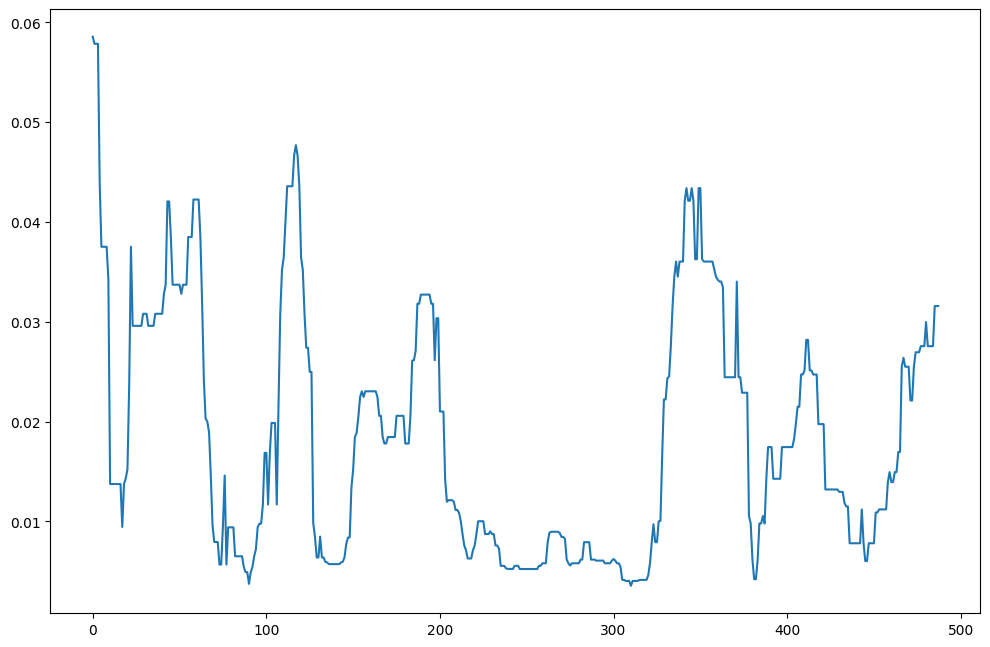

In [25]:
plt.plot(get_roll_mses(X[29], preds[29]))

plt.show()

In [22]:
# plt.rcParams['figure.figsize'] = [12, 8]
# plt.rcParams['figure.dpi'] = 100

In [24]:
modifs_idx[7]

array([array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 427, 428, 429, 430, 431])],
      dtype=object)

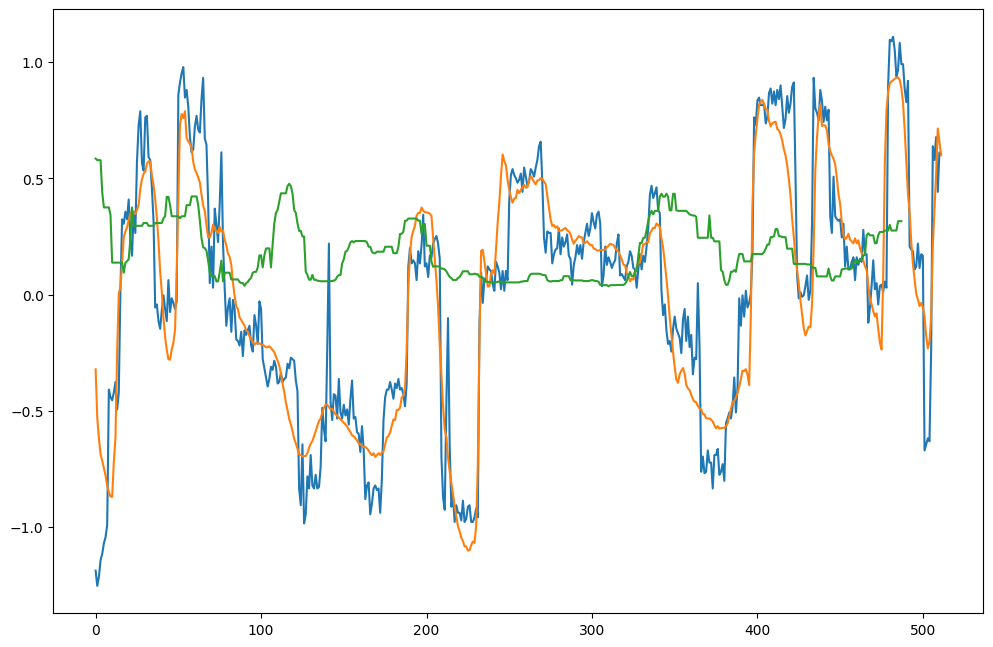

In [27]:
plt.plot(X[29].flatten())
plt.plot(preds[29].flatten())
plt.plot(get_roll_mses(X[29], preds[29]) *10)
plt.show()

In [95]:
modifs_idx[:20]

array([[array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 423, 424])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 427, 428, 429, 430, 431])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])],
       [array([ 56,  57,  58,  59,  60, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 327, 328, 329, 330])],
       [array([232, 233, 234, 235])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([

In [79]:
np.median(get_roll_mses(X[2], preds[2]))

0.003682124

In [80]:
np.median(get_roll_mses(X[-1], preds[-1]))

0.002750317

In [88]:
modifs_idx[:10]

array([[array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 423, 424])],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([], dtype=int64)],
       [array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 427, 428, 429, 430, 431])],
       [array([], dtype=int64)],
       [array([], dtype=int64)]], dtype=object)